In [1]:
from pandas import read_csv
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shapely.wkt
import geopandas as gpd
import contextily as cx
import constants as c

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync')

In [2]:
synthfirm_all = read_csv('outputs/synthetic_firms_v2.csv')
sf_map = gpd.read_file('inputs/Austin_freight.geojson')
mesozone_id_lookup = read_csv('inputs/zonal_id_lookup_final.csv')

lehd_validation = read_csv('inputs/LEHD_employment.csv')
sf_map.head(5)

/var/folders/w6/7qcyt43n21ddydhdfdslrp7c0000gp/T/ipykernel_15812/1842053662.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  synthfirm_all = read_csv('outputs/synthetic_firms_v2.csv')


,GEOID,CBPZONE,MESOZONE,geometry
0,483030018015,48303,4058.0,"MULTIPOLYGON (((-101.92240 33.55329, -101.9137..."
1,480291812003,48029,1188.0,"MULTIPOLYGON (((-98.53937 29.53751, -98.53230 ..."
2,481279502001,48127,2439.0,"MULTIPOLYGON (((-100.11434 28.64812, -100.0004..."
3,480291906041,48029,1367.0,"MULTIPOLYGON (((-98.52411 29.48090, -98.51597 ..."
4,480291715023,48029,1032.0,"MULTIPOLYGON (((-98.58195 29.42276, -98.58184 ..."


In [3]:
print(synthfirm_all.columns)
firm_by_zone = synthfirm_all.groupby(['MESOZONE']).agg({'BusID':'count',
                                                       'Emp':'sum'})
firm_by_zone = firm_by_zone.reset_index()
firm_by_zone.columns = ['MESOZONE', 'firm_count', 'employment_count']
firm_by_zone.head(5)

print(firm_by_zone[['firm_count', 'employment_count']].sum())

Index(['CBPZONE', 'FAFZONE', 'esizecat', 'Industry_NAICS6_Make',
       'Commodity_SCTG', 'Emp', 'BusID', 'MESOZONE'],
      dtype='object')
firm_count          8.397032e+06
employment_count    1.075930e+08
dtype: float64


In [4]:
print(mesozone_id_lookup.columns)
firm_by_zone = pd.merge(firm_by_zone, mesozone_id_lookup, on = 'MESOZONE', how = 'left')
firm_by_zone.head(5)

Index(['Unnamed: 0', 'GEOID', 'CBPZONE', 'MESOZONE', 'FAFID', 'FAFNAME'], dtype='object')


,MESOZONE,firm_count,employment_count,Unnamed: 0,GEOID,CBPZONE,FAFID,FAFNAME
0,1,31,93.675473,6796,480019501001,48001,489,Rest of TX
1,2,29,378.301451,3452,480019501002,48001,489,Rest of TX
2,3,29,248.507276,2359,480019501003,48001,489,Rest of TX
3,4,27,184.409939,3732,480019504011,48001,489,Rest of TX
4,5,30,173.476260,3068,480019504021,48001,489,Rest of TX


In [5]:
firm_in_study_area = firm_by_zone.loc[firm_by_zone['FAFID'].isin([481, 488, 489])]
print(firm_in_study_area.firm_count.sum())
# sf_map_with_firm = sf_map.merge(firm_in_austin, on='MESOZONE', how='inner')
# sf_map_with_firm.head(5)
synthfirm_in_study_area = synthfirm_all.loc[synthfirm_all['MESOZONE'] < 20000]
print(synthfirm_in_study_area.Emp.sum())
print(len(synthfirm_all.Industry_NAICS6_Make.unique()))
print(len(synthfirm_in_study_area.Industry_NAICS6_Make.unique()))

synthfirm_in_study_area.head(5)

257646
3050920.0008009886
409
399


,CBPZONE,FAFZONE,esizecat,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE
1015,48061,489,1,1111A0,3,1.0,1016,1967
1016,48119,489,1,1111A0,3,1.0,1017,2416
1017,48279,489,1,1111A0,3,1.0,1018,3844
1071,48453,481,1,1111A0,3,1.0,1072,5955
1075,48115,489,1,1111A0,3,1.0,1076,2395


3050920.0008009886


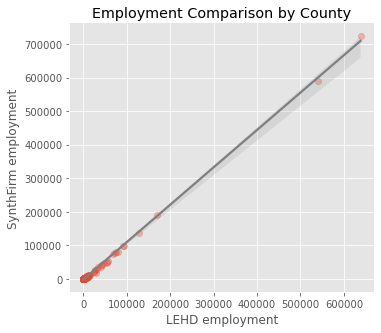

In [8]:
# compare to LEHD data
#lehd_validation.head(5)
lehd_firm_by_county = lehd_validation.loc[lehd_validation['industry'] == '0']
firm_in_study_area_by_county = firm_in_study_area.groupby('CBPZONE')[['employment_count']].sum()
firm_in_study_area_by_county = firm_in_study_area_by_county.reset_index()
# print(firm_in_study_area_by_county.head(5))

lehd_firm_by_county = lehd_firm_by_county.groupby('geography')[['EmpS']].mean()
lehd_firm_by_county = lehd_firm_by_county.reset_index()
# print(lehd_firm_by_county.head(5))
firm_comparison_by_county = pd.merge(lehd_firm_by_county, 
                                     firm_in_study_area_by_county,
                                     left_on = 'geography',
                                     right_on = 'CBPZONE',
                                     how = 'inner')
firm_comparison_by_county.columns = ['County', 'LEHD employment', 'CBPZONE', 'SynthFirm employment']
print(firm_comparison_by_county['SynthFirm employment'].sum())
firm_comparison_by_county.head(5)
plt.style.use('ggplot')
g = sns.lmplot(
    data=firm_comparison_by_county,
    x="LEHD employment", y="SynthFirm employment", 
    height=4.5, aspect = 1.2, line_kws={'color': 'grey'}, scatter_kws = {'alpha':0.3})
plt.title('Employment Comparison by County')
plt.savefig('plots/austin_emp_by_county_validation.png', dpi = 200,
           bbox_inches = 'tight')

3076348.7500000005
3050920.0008009886


/var/folders/w6/7qcyt43n21ddydhdfdslrp7c0000gp/T/ipykernel_15812/2640847542.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synthfirm_in_study_area.loc[:, 'Industry_NAICS6_Make'] = synthfirm_in_study_area.loc[:, 'Industry_NAICS6_Make'].astype(str)
/var/folders/w6/7qcyt43n21ddydhdfdslrp7c0000gp/T/ipykernel_15812/2640847542.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synthfirm_in_study_area.loc[:, 'NAICS2'] = synthfirm_in_study_area.loc[:, 'Industry_NAICS6_Make'].str[:2]
/var/folders/w6/7qcyt43n

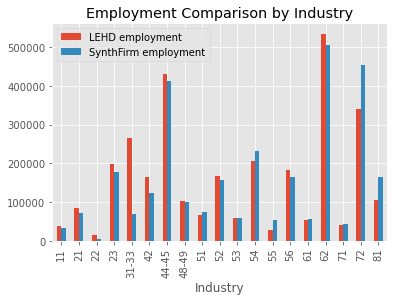

In [15]:
# compare to LEHD data
#lehd_validation.head(5)
industry_lookup = {'11':'11', '21':'21', '22':'22', '23':'23',
                   '31':'31-33', '32':'31-33', '33':'31-33',
                   '42':'42', '44':'44-45', '45':'44-45', '4A': '44-45',
                   '48':'48-49', '49':'48-49', '51':'51',
                   '52':'52', '53':'53', '54':'54', '55':'55',
                   '56':'56', '61':'61', '62':'62', '71':'71',
                   '72':'72', '81':'81', '92':'92', 'S0': '92'}
selected_counties = firm_comparison_by_county.County.unique()
lehd_firm_by_industry = lehd_validation.loc[lehd_validation['industry'] != '0']

# print(lehd_firm_by_industry.industry.unique())

lehd_firm_by_industry = lehd_firm_by_industry.groupby(['geography', 'industry'])[['EmpS']].mean()

lehd_firm_by_industry = lehd_firm_by_industry.reset_index()
lehd_firm_by_industry = \
lehd_firm_by_industry.loc[lehd_firm_by_industry['geography'].isin(selected_counties)]

lehd_firm_by_industry = lehd_firm_by_industry.groupby(['industry'])[['EmpS']].sum()
print(lehd_firm_by_industry['EmpS'].sum())

print(synthfirm_in_study_area.loc[:, 'Emp'].sum())
synthfirm_in_study_area.loc[:, 'Industry_NAICS6_Make'] = synthfirm_in_study_area.loc[:, 'Industry_NAICS6_Make'].astype(str)
synthfirm_in_study_area.loc[:, 'NAICS2'] = synthfirm_in_study_area.loc[:, 'Industry_NAICS6_Make'].str[:2]
# print(synthfirm_in_study_area.loc[:, 'NAICS2'].unique())
synthfirm_in_study_area.loc[:, 'industry'] = synthfirm_in_study_area.loc[:, 'NAICS2'].map(industry_lookup)

firm_in_study_area_by_industry = synthfirm_in_study_area.groupby(['industry'])[['Emp']].sum()
# print(firm_in_study_area_by_industry['Emp'].sum())
firm_in_study_area_by_industry = firm_in_study_area_by_industry.reset_index()
firm_comparison_by_industry = pd.merge(lehd_firm_by_industry,
                                       firm_in_study_area_by_industry,
                                       on = 'industry', how = 'inner')

firm_comparison_by_industry.columns = ['Industry', 'LEHD employment',  'SynthFirm employment']
# print(firm_comparison_by_industry['SynthFirm employment'].sum())
# print(firm_comparison_by_industry.head(5))
plt.style.use('ggplot')
firm_comparison_by_industry.plot(kind = 'bar',
    x="Industry")
plt.title('Employment Comparison by Industry')
plt.savefig('plots/austin_emp_by_industry_validation.png', dpi = 200)

In [16]:
firm_in_austin = firm_by_zone.loc[firm_by_zone['FAFID'].isin([481, 488, 489])]
sf_map_with_firm = sf_map.merge(firm_in_austin, on='MESOZONE', how='inner')
sf_map_with_firm.head(5)

,GEOID_x,CBPZONE_x,MESOZONE,geometry,firm_count,employment_count,Unnamed: 0,GEOID_y,CBPZONE_y,FAFID,FAFNAME
0,483030018015,48303,4058.0,"MULTIPOLYGON (((-101.92240 33.55329, -101.9137...",38,381.575084,0,483030018015,48303,489,Rest of TX
1,480291812003,48029,1188.0,"MULTIPOLYGON (((-98.53937 29.53751, -98.53230 ...",43,593.724030,1,480291812003,48029,488,San Antonio
2,481279502001,48127,2439.0,"MULTIPOLYGON (((-100.11434 28.64812, -100.0004...",53,360.400916,2,481279502001,48127,489,Rest of TX
3,480291906041,48029,1367.0,"MULTIPOLYGON (((-98.52411 29.48090, -98.51597 ...",42,341.776003,3,480291906041,48029,488,San Antonio
4,480291715023,48029,1032.0,"MULTIPOLYGON (((-98.58195 29.42276, -98.58184 ...",37,519.527576,4,480291715023,48029,488,San Antonio


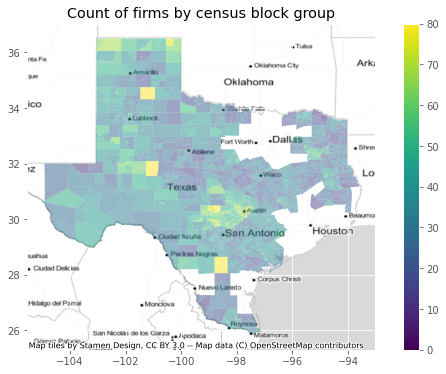

In [17]:
ax = sf_map_with_firm.plot(figsize = (10,6), column = 'firm_count', 
                           vmin=0, vmax=80, alpha = 0.5, legend=True)
cx.add_basemap(ax, crs = 'EPSG:4326', source = cx.providers.Stamen.TonerLite)
plt.title('Count of firms by census block group')
plt.savefig('plots/austin_region_firm_count.png', dpi = 200)

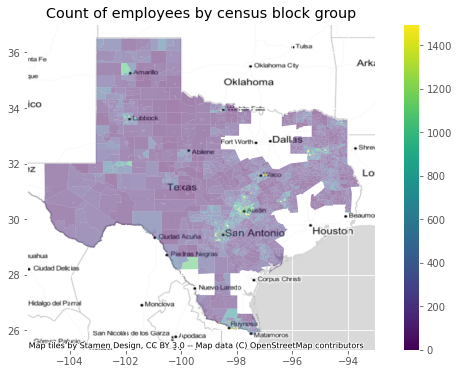

In [19]:
ax = sf_map_with_firm.plot(figsize = (10,6), column = 'employment_count', 
                            vmin=0, vmax=1500, alpha = 0.5, legend=True)
cx.add_basemap(ax, crs = 'EPSG:4326',source = cx.providers.Stamen.TonerLite)
plt.title('Count of employees by census block group')
plt.savefig('plots/austin_region_emp_count.png', dpi = 200)